In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import sympy


Bad key "text.kerning_factor" on line 4 in
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average

np.random.seed(0)
random.seed(42)

In [3]:
edges = np.loadtxt('facebook_combined.txt',dtype=int)

G = nx.Graph()
G.add_edges_from(edges)

G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()
print(G_no_nodes,G_no_edges)

4039 88234


Modularity for best partition: 0.8349145565366209


/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


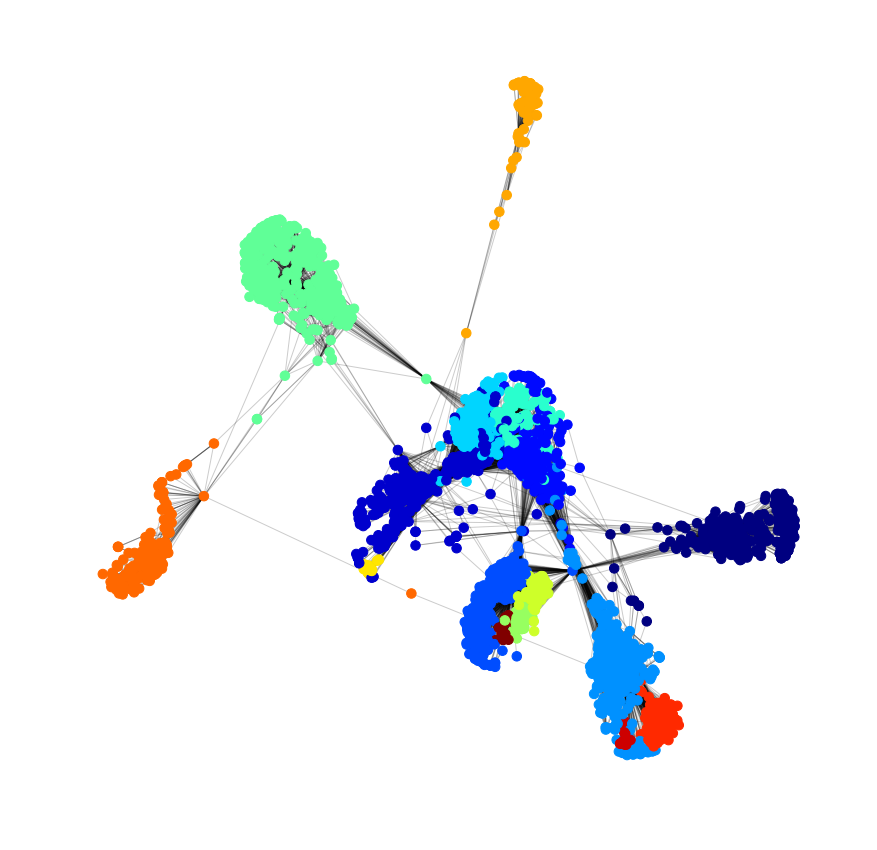

In [4]:
from louvain import detect_communities, modularity
def draw_communities(G, node_size=90, alpha=1, k=None, randomized=False):
    partition = detect_communities(G, randomized=randomized)
    print("Modularity for best partition:", modularity(G, partition))
    community_map = {}
    for community, nodes in enumerate(partition):
        for node in nodes:
            community_map[node] = community
    
    cmap = plt.get_cmap("jet")
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=k)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
    for x in range(len(pos)):
        pos[x] = pos[x]+np.array([0.02,0])
    labels = dict([(n, n) for n in G.nodes()]) #add labels
    #_ = nx.draw_networkx_labels(G, pos, labels=labels, font_color='#000000', font_size=15) #draw labels
draw_communities(G)

In [5]:
partition = detect_communities(G, randomized=False)
community_map = {}
node_map = {}

for community, nodes in enumerate(partition):
    for node in nodes:
        node_map[node] = community
    community_map[community] = nodes

In [6]:
K = 20

def MHRR_sampling(G,B,U=None):
    restart_ind = [10]
    t=20
    while restart_ind[-1]<B:
        restart_ind.append(restart_ind[-1]+int(K*np.log(t)))
        t+=1
    
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

In [7]:
def MHRR_sampling_n(G,B,U=None):
    restart_ind = [10]
    t=11
    while t<B:
        if np.random.random()<50/(50+t):
            restart_ind.append(t)
        t+=1
    
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)


def MHRR_sampling_log(G,B,U=None):
    restart_ind = [10]
    t=11
    while t<B:
        if np.random.random()<1/(1+80*np.log(t)):
            restart_ind.append(t)
        t+=1
    
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

## Finding High Degree Nodes in Clusters

In [8]:
U = []

for com in list(community_map.keys()):
    nodes = community_map[com]
    maxd = -1
    maxn = -1
    for node in nodes:
        if G.degree(node)>maxd:
            maxd = G.degree(node)
            maxn = node
    U.append(maxn)

## F(v) = int(node_map[node] == 1)

In [9]:
def node_fn(node):
    return int(node_map[node]==1)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.10670958157959891


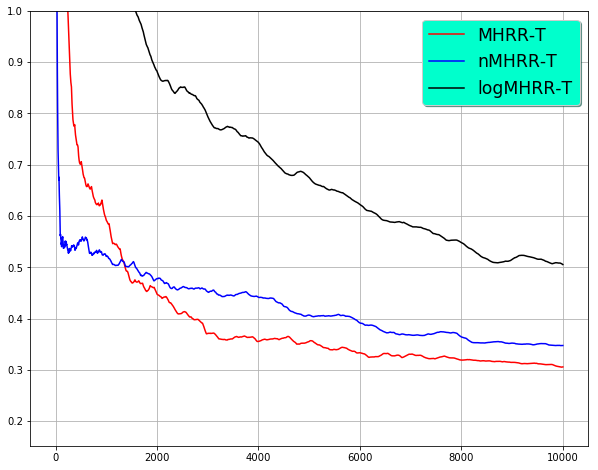

In [10]:
MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_n(G,max_B,U)-F_org)**2
MSE_mhrr_n = MSE_mhrr_t/(no_runs)
MSE_mhrr_n = np.sqrt(MSE_mhrr_n)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_log(G,max_B,U)-F_org)**2
MSE_mhrr_log = MSE_mhrr_t/(no_runs)
MSE_mhrr_log = np.sqrt(MSE_mhrr_log)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='red',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_n)))),MSE_mhrr_n,color='blue',linewidth=1.5,label='nMHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_log)))),MSE_mhrr_log,color='black',linewidth=1.5,label='logMHRR-T')
plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend = plt.legend(shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('#00FFCC')
plt.ylim(top=1)
plt.grid()

## F(v) = int(G.degree(node)>100)

In [11]:
def node_fn(node):
    return int(G.degree(node)>100)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.11908888338697697


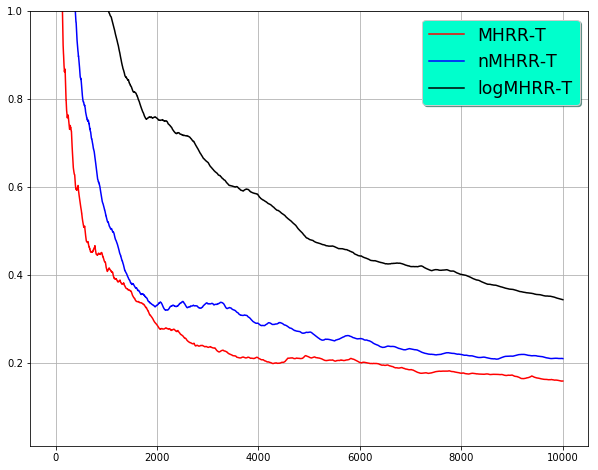

In [12]:
MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_n(G,max_B,U)-F_org)**2
MSE_mhrr_n = MSE_mhrr_t/(no_runs)
MSE_mhrr_n = np.sqrt(MSE_mhrr_n)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_log(G,max_B,U)-F_org)**2
MSE_mhrr_log = MSE_mhrr_t/(no_runs)
MSE_mhrr_log = np.sqrt(MSE_mhrr_log)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='red',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_n)))),MSE_mhrr_n,color='blue',linewidth=1.5,label='nMHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_log)))),MSE_mhrr_log,color='black',linewidth=1.5,label='logMHRR-T')
plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend = plt.legend(shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('#00FFCC')
plt.ylim(top=1)
plt.grid()

## F(v) = isprime(v)

In [13]:
def node_fn(node):
    return int(sympy.isprime(G.degree(node)))
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.2904184204010894


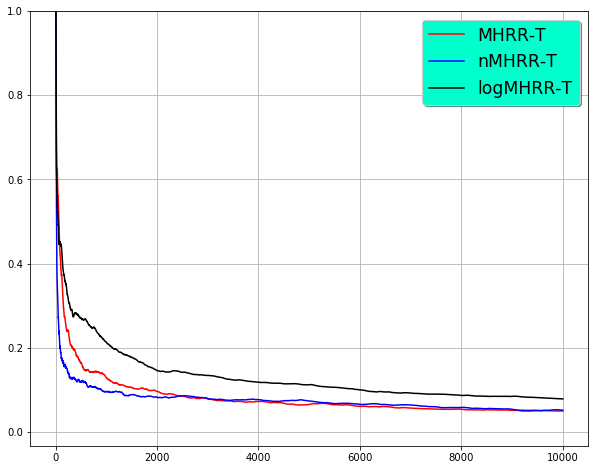

In [14]:
MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_n(G,max_B,U)-F_org)**2
MSE_mhrr_n = MSE_mhrr_t/(no_runs)
MSE_mhrr_n = np.sqrt(MSE_mhrr_n)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_log(G,max_B,U)-F_org)**2
MSE_mhrr_log = MSE_mhrr_t/(no_runs)
MSE_mhrr_log = np.sqrt(MSE_mhrr_log)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='red',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_n)))),MSE_mhrr_n,color='blue',linewidth=1.5,label='nMHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_log)))),MSE_mhrr_log,color='black',linewidth=1.5,label='logMHRR-T')
plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend = plt.legend(shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('#00FFCC')
plt.ylim(top=1)
plt.grid()

## F(v) = random

In [15]:
fn_mapping = np.random.exponential(1,size=(G_no_nodes))
def node_fn(node):
    return fn_mapping[node]

F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)    

1.0113744482676896


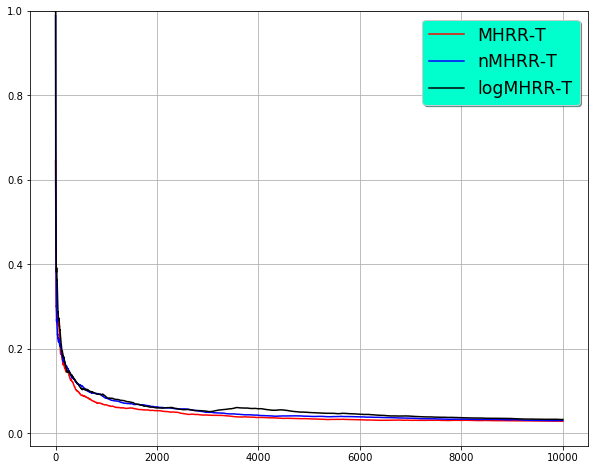

In [16]:
MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B,U)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_n(G,max_B,U)-F_org)**2
MSE_mhrr_n = MSE_mhrr_t/(no_runs)
MSE_mhrr_n = np.sqrt(MSE_mhrr_n)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling_log(G,max_B,U)-F_org)**2
MSE_mhrr_log = MSE_mhrr_t/(no_runs)
MSE_mhrr_log = np.sqrt(MSE_mhrr_log)/F_org


plt.figure(figsize=(10,8)) 
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='red',linewidth=1.5,label='MHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_n)))),MSE_mhrr_n,color='blue',linewidth=1.5,label='nMHRR-T')
plt.plot(np.array(list(range(len(MSE_mhrr_log)))),MSE_mhrr_log,color='black',linewidth=1.5,label='logMHRR-T')
plt.legend(loc='best', shadow=True, fontsize='xx-large')
legend = plt.legend(shadow=True, fontsize='xx-large')
legend.get_frame().set_facecolor('#00FFCC')
plt.ylim(top=1)
plt.grid()